In [3]:
%pip install torch
%pip install matplotlib
%pip install numpy


     ---------------------------------------- 8.1/8.1 MB 276.4 kB/s eta 0:00:00
  Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
     ---------------------------------------- 2.2/2.2 MB 1.0 MB/s eta 0:00:00
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)
     -------------------------------------- 12.9/12.9 MB 726.9 kB/s eta 0:00:00
     -------------------------------------- 71.9/71.9 kB 395.2 kB/s eta 0:00:00
     ------------------------------------ 221.2/221.2 kB 518.3 kB/s eta 0:00:00
     ---------------------------------------- 2.7/2.7 MB 476.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
# Raycast-Based Ball Position & Velocity Prediction
# Inspired by biological vision

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# 1. Simulated Raycast Generator

In [28]:
# def simulate_raycast_sequence(seq_len=5, num_rays=16, fov=60, starting_angle=-30, max_range=5.5, ball_radius=0.022):
#     ray_angles = np.linspace(fov / 2, fov / 2, num_rays) + starting_angle
#     ray_angles = np.deg2rad(ray_angles)
#     ball_pos = np.random.uniform(low=[-1, 0.2], high=[1, 0.8])
#     ball_vel = np.random.uniform(low=[-0.05, -0.02], high=[0.05, 0.02])

#     eyeball_pos = np.array([0.0, 0.0])
#     sequence = []

#     for t in range(seq_len):
#         rays = []
#         ball_c = ball_pos + ball_vel * t

#         for angle in ray_angles:
#             dir_vec = np.array([np.cos(angle), np.sin(angle)])
#             oc = ball_c - eyeball_pos
#             b = 2 * np.dot(oc, dir_vec)
#             c = np.dot(oc, oc) - ball_radius**2
#             discriminant = b**2 - 4 * c
#             if discriminant < 0:
#                 rays.append(10.0)  # No hit
#             else:
#                 dist = (-b - np.sqrt(discriminant)) / 2
#                 rays.append(max(dist, 0.0))

#         sequence.append(rays)

#     return np.array(sequence), np.concatenate([ball_c, ball_vel])

In [29]:
# # Generate dataset
# X, y = [], []
# for _ in range(10000):
#     ray_seq, target = simulate_raycast_sequence()
#     X.append(ray_seq)
#     y.append(target)

# X = np.stack(X)  # (N, T, R)
# y = np.stack(y)  # (N, 4)

# 1. Load Data

In [6]:
X = np.load('data/collected_data_big_input.npy')
y = np.load('data/collected_data_big_output.npy')
# X = np.load('/content/drive/MyDrive/data/collected_data_big_input.npy')
# y = np.load('/content/drive/MyDrive/data/collected_data_big_output.npy')
print("Input shape:", X.shape)
print("Output shape:", y.shape)

Input shape: (158479, 5, 107)
Output shape: (158479, 4)


In [56]:
print(np.mean(X), np.std(X))
print(np.mean(y[:, :2]), np.std(y[:, :2]))
print(np.mean(y[:, 2:]), np.std(y[:, 2:]))

-0.9510646251092353 0.38554776172805133
-0.45978473352598437 1.0362819685902789
-0.661714303036759 1.7142335210125879


# 2. Visualize a Sample

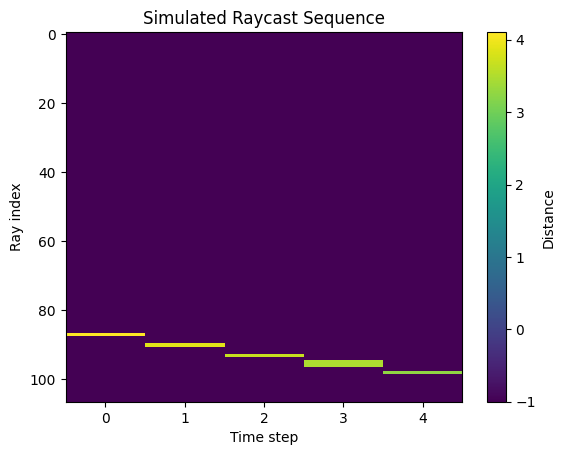

In [7]:
# -----------------------------
# 2. Visualize a Sample
# -----------------------------
def visualize_rays(ray_seq):
    plt.imshow(ray_seq.T, aspect='auto', cmap='viridis')
    plt.xlabel("Time step")
    plt.ylabel("Ray index")
    plt.title("Simulated Raycast Sequence")
    plt.colorbar(label="Distance")
    plt.show()

visualize_rays(X[0])



# LSTM Model

In [8]:
class RaycastLSTM(nn.Module):
    def __init__(self, num_rays, hidden_size=64, output_size=4):
        super().__init__()
        self.lstm = nn.LSTM(input_size=num_rays, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 64),
            nn.ReLU(),
            nn.Linear(64, output_size)
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        last_output = lstm_out[:, -1, :]
        return self.fc(last_output)


# 4. Training

In [58]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

model = RaycastLSTM(num_rays=X.shape[2])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

losses = []
for epoch in range(100):
    epoch_loss = 0
    for xb, yb in loader:
        pred = model(xb)
        loss = criterion(pred, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    losses.append(epoch_loss / len(loader))
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {epoch_loss / len(loader):.4f}")

Epoch 0: Loss = 0.9566
Epoch 10: Loss = 0.4648
Epoch 20: Loss = 0.3987
Epoch 30: Loss = 0.3583
Epoch 40: Loss = 0.3303
Epoch 50: Loss = 0.3095
Epoch 60: Loss = 0.2950
Epoch 70: Loss = 0.2839
Epoch 80: Loss = 0.2740
Epoch 90: Loss = 0.2650


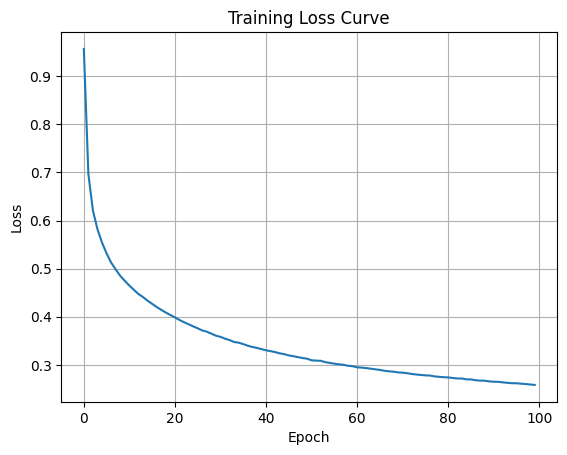

In [59]:
# Plot training loss
plt.plot(losses)
plt.xlabel("Epoch")
# plt.xticks(range(len(losses)), range(1, len(losses) + 1))
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.grid(True)
plt.show()

# 5. Eval

In [60]:
X_test = np.load('data/collected_test_data_input.npy')
y_test = np.load('data/collected_test_data_output.npy')

In [61]:
model.eval()
with torch.no_grad():
    i = np.random.randint(0, len(X_test) - 1)
    test_seq = X_test[0]
    test_target = y_test[0]
    input_tensor = torch.tensor([test_seq], dtype=torch.float32)
    prediction = model(input_tensor)[0].numpy()
    print("Predicted:", prediction)
    print("Ground Truth:", test_target)  # [x, y, vx, vy]

Predicted: [ 0.45159668  1.0471832  -4.255524    0.53869754]
Ground Truth: [ 0.54564544  0.9435534  -3.97647731  0.4462975 ]


In [62]:
true_vel = []
pred_vel = []
true_pos = []
pred_pos = []

model.eval()
with torch.no_grad():
    idx = np.random.randint(0, len(X_test) - 1, 30)

    for i in idx:
        test_seq = X_test[i]
        test_target = y_test[i]
        input_tensor = torch.tensor([test_seq], dtype=torch.float32)
        prediction = model(input_tensor)[0].numpy()

        true_pos.append(test_target[:2])
        true_vel.append(test_target[2:])
        pred_pos.append(prediction[:2])
        pred_vel.append(prediction[2:])
    # print("Predicted:", prediction)
    # print("Ground Truth:", test_target)  # [x, y, vx, vy]

In [63]:
x_coords_true_vel, y_coords_true_vel = zip(*true_vel)
x_coords_pred_vel, y_coords_pred_vel = zip(*pred_vel)
x_coords_true_pos, y_coords_true_pos = zip(*true_pos)
x_coords_pred_pos, y_coords_pred_pos = zip(*pred_pos)

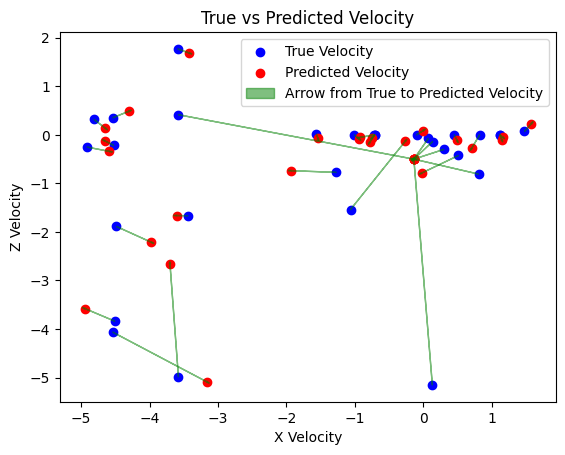

In [64]:
plt.scatter(x_coords_true_vel, y_coords_true_vel, color='blue', label='True Velocity')
plt.scatter(x_coords_pred_vel, y_coords_pred_vel, color='red', label='Predicted Velocity')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_vel[i], y_coords_true_vel[i], x_coords_pred_vel[i]-x_coords_true_vel[i], y_coords_pred_vel[i]-y_coords_true_vel[i], 
              head_width=0.02, head_length=0.05, fc='green', ec='green', alpha=0.5, label="Arrow from True to Predicted Velocity" if i == 0 else "")
plt.title("True vs Predicted Velocity")
plt.xlabel("X Velocity")
plt.ylabel("Z Velocity")
plt.legend()


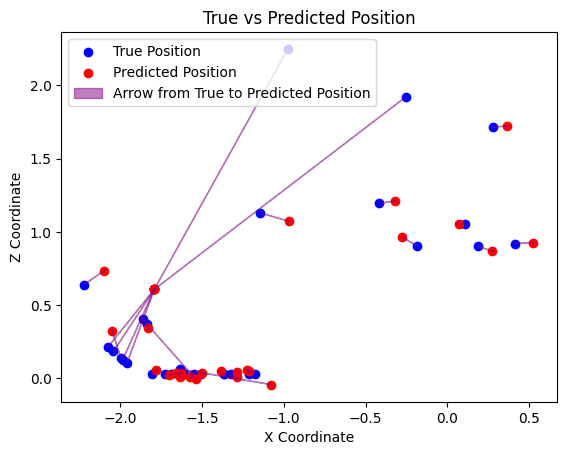

In [65]:
plt.scatter(x_coords_true_pos, y_coords_true_pos, color='blue', label='True Position')
plt.scatter(x_coords_pred_pos, y_coords_pred_pos, color='red', label='Predicted Position')
for i in range(len(x_coords_true_vel)):
    plt.arrow(x_coords_true_pos[i], y_coords_true_pos[i], x_coords_pred_pos[i]-x_coords_true_pos[i], y_coords_pred_pos[i]-y_coords_true_pos[i], 
              head_width=0.005, head_length=0.01, fc='purple', ec='purple', alpha=0.5, label="Arrow from True to Predicted Position" if i == 0 else "")
plt.title("True vs Predicted Position")
plt.xlabel("X Coordinate")
plt.ylabel("Z Coordinate")
plt.legend()